<a href="https://colab.research.google.com/github/kolo-vrat/detect-malicious-url-ml/blob/main/DetectMaliciousURL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Земање на податоците

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os import path

DATASET_PATH = path.join("dataset", "urls.csv")

def load_data(csv_path=DATASET_PATH):
    return pd.read_csv(csv_path)

In [ ]:
data = load_data()
data.head()

,url,label
0,https://www.tv.fopii.com/tvseries/p3_1947_0.html,benign
1,https://www.njcleancities.org/,benign
2,https://www.irhal.com/Montreal/Expensive-Shopp...,benign
3,https://www.eforu.com/birthdays/March_30.html,benign
4,https://www.en.wikipedia.org/wiki/Unaccompanie...,benign


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 447502 entries, 0 to 447501
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     447502 non-null  object
 1   label   447502 non-null  object
dtypes: object(2)
memory usage: 6.8+ MB


In [ ]:
data["label"].value_counts()

benign       345599
malicious    101903
Name: label, dtype: int64

In [ ]:
data["label"] = data["label"].map({"benign": 1}).fillna(0).astype(int)

In [ ]:
data

,url,label
0,https://www.tv.fopii.com/tvseries/p3_1947_0.html,1
1,https://www.njcleancities.org/,1
2,https://www.irhal.com/Montreal/Expensive-Shopp...,1
3,https://www.eforu.com/birthdays/March_30.html,1
4,https://www.en.wikipedia.org/wiki/Unaccompanie...,1
...,...,...
447497,https://www.names.whitepages.com/james/lavoie,1
447498,https://www.virtualmuseum.ca/Exhibitions/Medic...,1
447499,https://www.nws.noaa.gov/com/presentations/hay...,1
447500,https://www.moviemusic.com/soundtrack/M02912/m...,1


## Екстрактирање на features

In [ ]:
import re

from urllib.parse import urlparse
from math import log2
from sklearn.base import TransformerMixin

class ExtractFeatures:
    def __init__(self, url: str):
        self.url = url
        self.urlparse = urlparse(url)

    def __length(self):
        return len(self.url)

    def __length_primary_domain(self):
        if self.__host_is_ip(): return 0
        if self.urlparse.hostname.count('.') > 1:
            domain = self.urlparse.hostname.split('.')
            length = len(domain[-1]) + len(domain[-2]) + 1 #domain name + . + tld
        else:
            length = len(self.urlparse.hostname)
        return length

    def __length_primary_domain_length_url_ratio(self):
        return self.__length_primary_domain() / self.__length()

    def __length_path(self):
        return len(self.urlparse.path) if self.urlparse.path else 0

    def __length_path_length_url_ratio(self):
        return self.__length_path() / self.__length()

    def __number_digits(self):
        return len(list(filter((lambda x: x.isdigit()), self.url)))

    def __number_special_characters(self):
        special_chars = [
            ':', '//', '.', ':',
            '/', '?=', ',', ';',
            '(',')',']','+'
        ]
        num = 0
        for char in special_chars:
            if char in self.url:
                num += self.url.count(char)
        return num

    def __number_special_characters_path(self):
        special_chars = [
            ':', '//', '.', ':',
            '/', '?=', ',', ';',
            '(',')',']','+'
        ]
        num = 0
        for char in special_chars:
            if char in self.urlparse.path:
                num += self.urlparse.path.count(char)
        return num

    def __number_dots(self):
        return self.url.count('.')

    def __number_subdomains(self):
        if self.__host_is_ip(): return 0
        if self.urlparse.hostname.count('.') > 1:
            num_sub = len(self.urlparse.hostname.split('.')) - 2
        else: num_sub = 0
        return num_sub

    def __url_scheme(self):
        if self.urlparse.scheme is None:
            scheme = 0
        else:
            if self.urlparse.scheme == 'https':
                scheme = 1
            else:
                scheme = 2
        return scheme

    def __host_is_ip(self):
        host = self.urlparse.netloc
        pattern = re.compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return 1 if match is not None else 0

    def __host_has_port(self):
        return 1 if self.urlparse.port else 0

    def __digit_letter_ratio(self):
        letters = len(list(filter((lambda x: x.isalpha()), self.url)))
        digits = self.__number_digits()
        return digits / letters

    def __number_path_subdirectories(self):
        d = self.urlparse.path.split('/')
        return len(d)

    def __number_single_character_directories(self):
        d = self.urlparse.path.split('/')
        singles_list = [x for x in d if len(x) == 1]
        return len(singles_list)

    def __number_queries(self):
        return len(self.urlparse.query.split('&'))

    def __is_encoded(self):
        return 1 if '%' in self.url.lower() else 0

    def __number_encoded_char(self):
        encs = [i for i in self.url if i == '%']
        return len(encs)

    def __url_entropy(self):
        url = self.url.lower()
        probs = [url.count(c) / len(url) for c in set(url)]
        entropy = -sum([p * log2(p) for p in probs])
        return entropy

    def get_features(self):
        feature_vector = np.array([
            self.__length(),
            self.__length_primary_domain(),
            self.__length_primary_domain_length_url_ratio(),
            self.__length_path(),
            self.__length_path_length_url_ratio(),
            self.__number_digits(),
            self.__number_special_characters(),
            self.__number_special_characters_path(),
            self.__number_dots(),
            self.__number_subdomains(),
            self.__url_scheme(),
            self.__host_is_ip(),
            self.__host_has_port(),
            self.__digit_letter_ratio(),
            self.__number_path_subdirectories(),
            self.__number_single_character_directories(),
            self.__number_queries(),
            self.__is_encoded(),
            self.__number_encoded_char(),
            self.__url_entropy()
        ])
        return feature_vector


class URLTransformer(TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        feature_columns = [
            "length", "primary_domain_length", "primary_domain_length_url_length_ratio", "path_length",
            "path_length_url_length_ratio", "number_digits", "number_special_characters", "number_special_characters_path",
            "number_dots", "number_subdomains", "url_scheme", "host_is_ip", "host_has_port",
            "digit_letter_ratio", "number_path_subdirectories", "number_single_character_directories",
            "number_queries", "is_encoded", "number_encoded_char", "url_entropy"
        ]
        data = [ExtractFeatures(url).get_features() for url in X["url"]]
        df = pd.DataFrame(data=data, columns=feature_columns)
        return df


In [ ]:
url_transformer = URLTransformer()
data_set = url_transformer.transform(data)
data_set = data_set.join(data["label"]) # Ja dodavame kolonata sto treba da ja predvidime
data = None

In [ ]:
data_set

,length,primary_domain_length,primary_domain_length_url_length_ratio,path_length,path_length_url_length_ratio,number_digits,number_special_characters,number_special_characters_path,number_dots,number_subdomains,...,host_is_ip,host_has_port,digit_letter_ratio,number_path_subdirectories,number_single_character_directories,number_queries,is_encoded,number_encoded_char,url_entropy,label
0,48.0,9.0,0.187500,24.0,0.500000,6.0,11.0,3.0,4.0,2.0,...,0.0,0.0,0.193548,3.0,0.0,1.0,0.0,0.0,4.363521,1
1,30.0,17.0,0.566667,1.0,0.033333,0.0,8.0,1.0,2.0,1.0,...,0.0,0.0,0.000000,2.0,0.0,1.0,0.0,0.0,4.031402,1
2,74.0,9.0,0.121622,53.0,0.716216,0.0,11.0,4.0,3.0,1.0,...,0.0,0.0,0.000000,4.0,0.0,1.0,0.0,0.0,4.351346,1
3,45.0,9.0,0.200000,24.0,0.533333,2.0,10.0,3.0,3.0,1.0,...,0.0,0.0,0.058824,3.0,0.0,1.0,0.0,0.0,4.358085,1
4,53.0,13.0,0.245283,25.0,0.471698,0.0,10.0,2.0,3.0,2.0,...,0.0,0.0,0.000000,3.0,0.0,1.0,0.0,0.0,4.161212,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
447497,45.0,14.0,0.311111,13.0,0.288889,0.0,10.0,2.0,3.0,2.0,...,0.0,0.0,0.000000,3.0,0.0,1.0,0.0,0.0,4.027980,1
447498,69.0,16.0,0.231884,41.0,0.594203,0.0,12.0,5.0,3.0,1.0,...,0.0,0.0,0.000000,5.0,0.0,1.0,0.0,0.0,4.223061,1
447499,52.0,8.0,0.153846,28.0,0.538462,0.0,12.0,4.0,4.0,2.0,...,0.0,0.0,0.000000,4.0,0.0,1.0,0.0,0.0,4.001619,1
447500,57.0,14.0,0.245614,31.0,0.543860,5.0,11.0,4.0,2.0,1.0,...,0.0,0.0,0.116279,5.0,0.0,1.0,0.0,0.0,4.370011,1


## Анализирање на податоците

<Axes: xlabel='label', ylabel='length'>

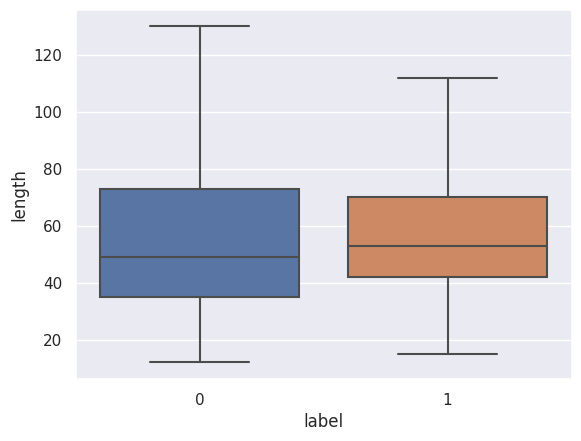

In [ ]:
sns.set()
sns.boxplot(x=data_set["label"], y=data_set["length"], showfliers = False) # Kaj se naogjaat najgolem del od podatocite

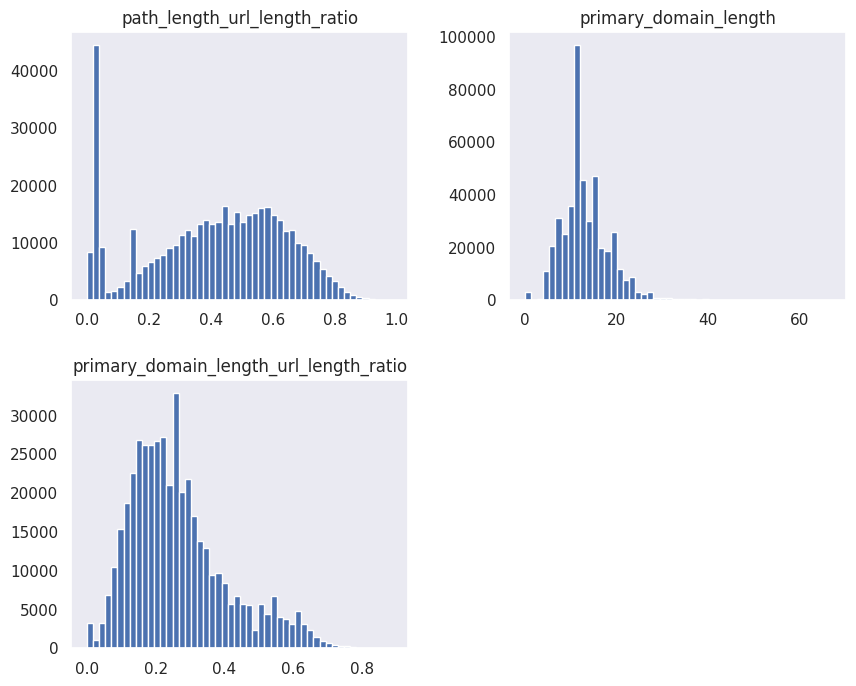

In [ ]:
columns = ["path_length_url_length_ratio", "primary_domain_length", "primary_domain_length_url_length_ratio"]
data_set.hist(column=columns, bins=50, grid=False, figsize=(10,8))
plt.show()


<Axes: >

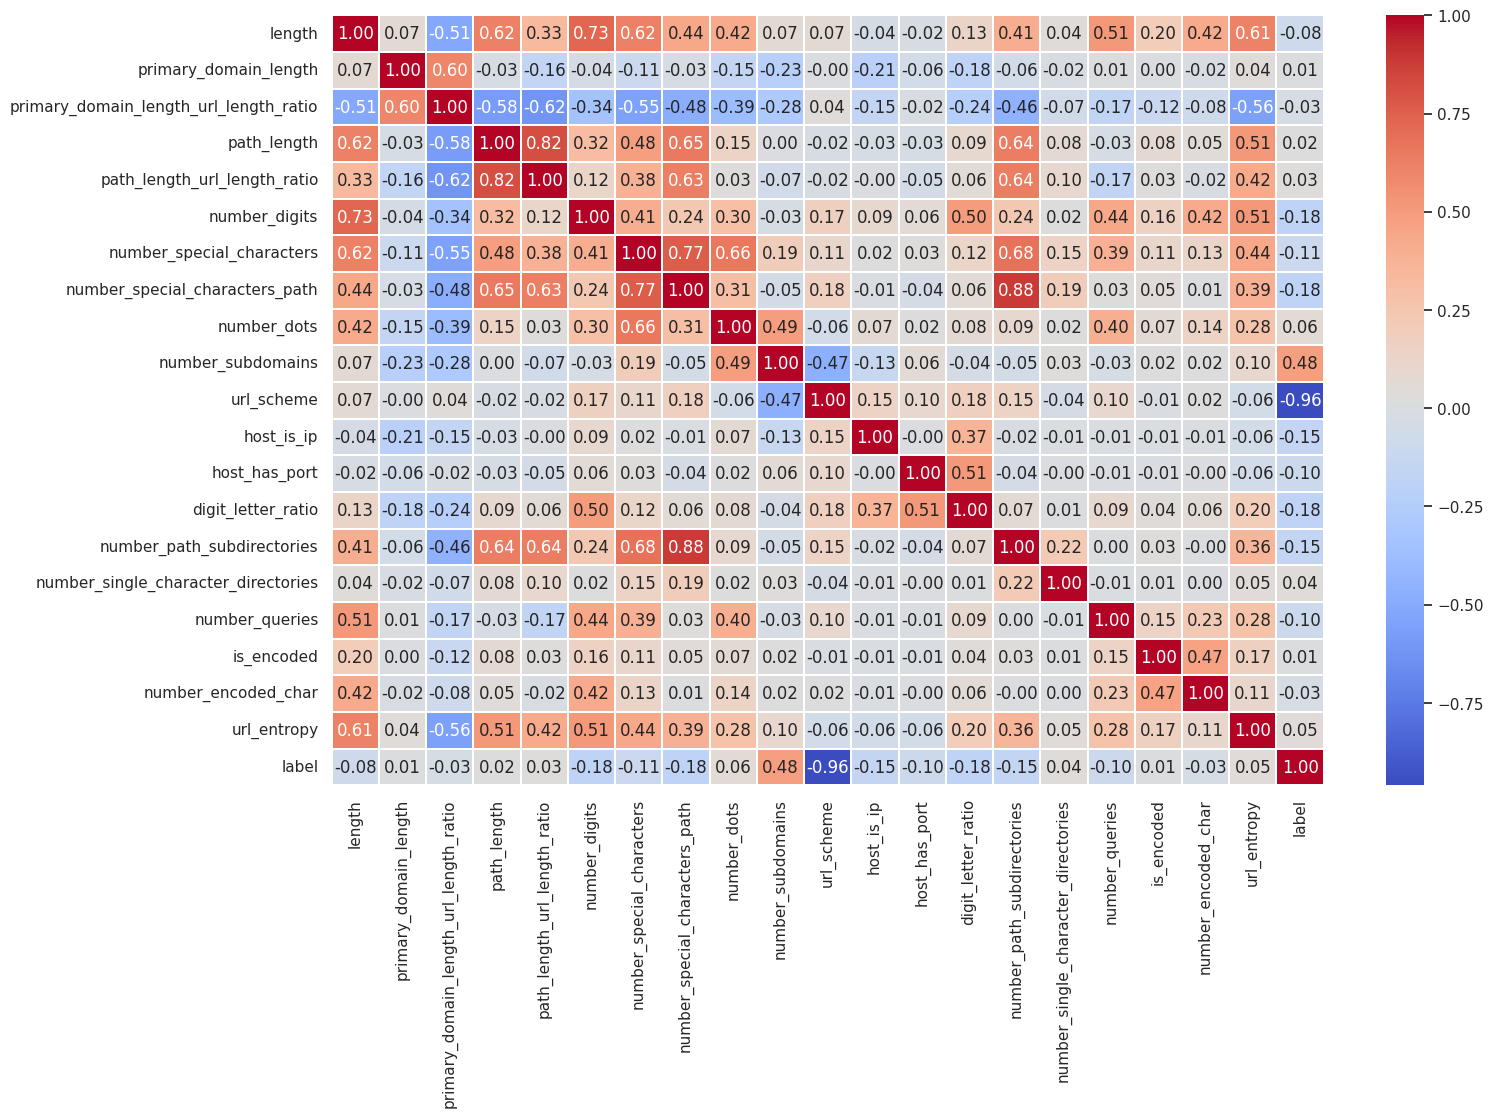

In [ ]:
fig = plt.figure(figsize = (16, 10))
ax = fig.add_subplot(1,1, 1)
corr = data_set.corr()
sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm", fmt='.2f', linewidths=.05)

## Поделба на тренинг и тест множества

### Random sampling

In [ ]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(data_set, test_size=0.1, random_state=42)

### Stratified sampling

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, test_index in split.split(data_set, data_set["label"]):
    strat_train_set = data_set.loc[train_index]
    strat_test_set = data_set.loc[test_index]

### Компарација

In [ ]:
overall = data["label"].value_counts() / len(data)
stratified_split = strat_test_set["label"].value_counts() / len(strat_test_set)
random_split = test_set["label"].value_counts() / len(strat_test_set)
comparation = pd.concat([overall, stratified_split, random_split], axis=1)
comparation.columns = ["Overall", "Stratified", "Random"]
comparation["Strat error(%)"] = (comparation["Overall"] - comparation["Stratified"]) * 100
comparation["Random error(%)"] = (comparation["Overall"] - comparation["Random"]) * 100
comparation

,Overall,Stratified,Random,Strat error(%),Random error(%)
1,0.772285,0.772296,0.773949,-0.001077,-0.166437
0,0.227715,0.227704,0.226051,0.001077,0.166437


In [ ]:
X_train, y_train = strat_train_set.iloc[:, :-1], strat_train_set.iloc[:, -1]
X_test, y_test = strat_test_set.iloc[:, :-1], strat_test_set.iloc[:, -1]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(402751, 20)
(402751,)
(44751, 20)
(44751,)


## Тренирање на модели на машинско учење

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### Decision Tree

In [ ]:
dt_clf = DecisionTreeClassifier()
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier()

In [ ]:
y_pred = dt_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {(accuracy * 100.0):.2f}")

Accuracy: 99.26


### Random Forest

In [ ]:
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
y_pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {(accuracy * 100.0):.2f}")

Accuracy: 99.57


<BarContainer object of 20 artists>

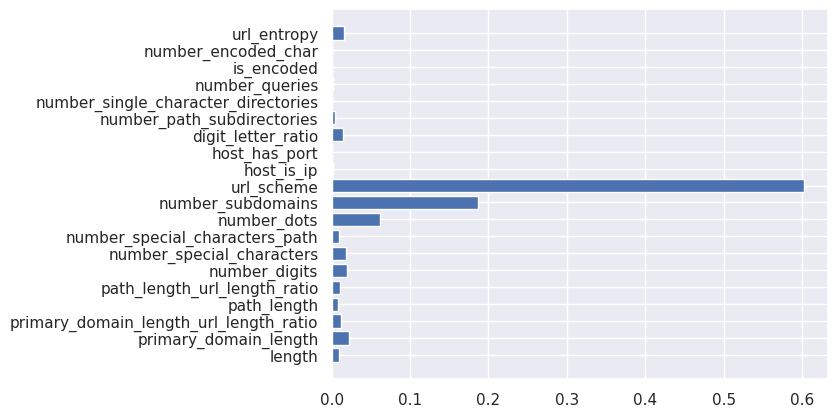

In [ ]:
plt.barh(X_train.columns, rf_clf.feature_importances_)

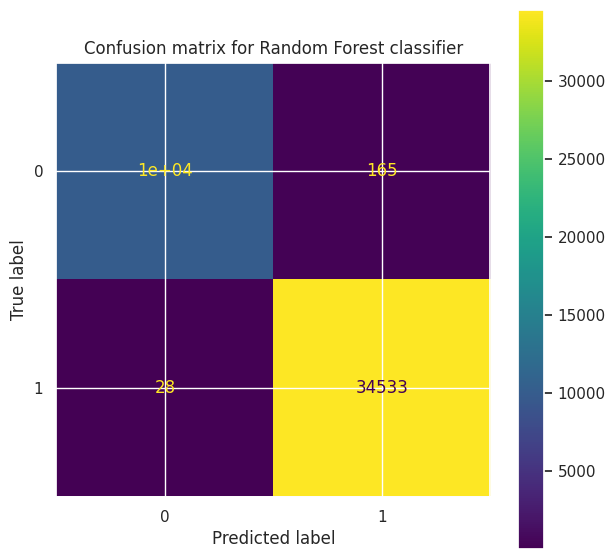

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Random Forest classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     10190
           1       1.00      1.00      1.00     34561

    accuracy                           1.00     44751
   macro avg       1.00      0.99      0.99     44751
weighted avg       1.00      1.00      1.00     44751



### Naive Bayes

In [ ]:
nb_clf = GaussianNB()
nb_clf.fit(X_train, y_train)

GaussianNB()

In [ ]:
y_pred = nb_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {(accuracy * 100.0):.2f}")

Accuracy: 97.86


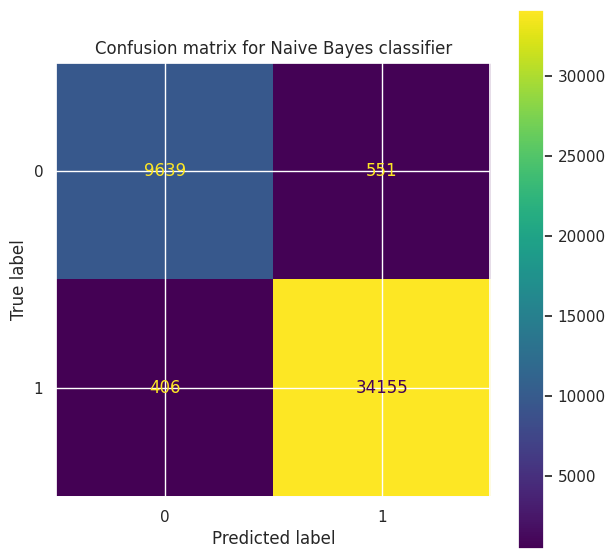

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Naive Bayes classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.95     10190
           1       0.98      0.99      0.99     34561

    accuracy                           0.98     44751
   macro avg       0.97      0.97      0.97     44751
weighted avg       0.98      0.98      0.98     44751



### Logistic Regression

In [ ]:
lr_clf = LogisticRegression(penalty='l2', multi_class='multinomial', max_iter=300, warm_start=True, n_jobs=-1)
lr_clf.fit(X_train, y_train)

/home/aleksandar/.local/share/virtualenvs/MaliciousURL-V2gZyrQw/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=300, multi_class='multinomial', n_jobs=-1,
                   warm_start=True)

In [ ]:
y_pred = lr_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {(accuracy * 100.0):.2f}")

Accuracy: 98.70


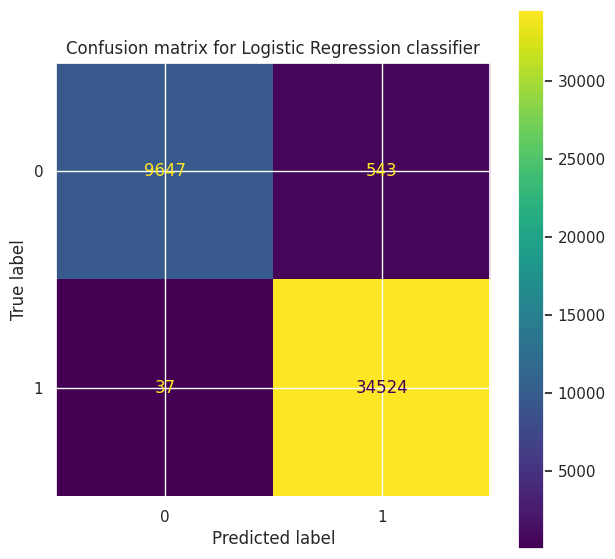

In [ ]:
fig, ax = plt.subplots(figsize=(7,7))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title('Confusion matrix for Logistic Regression classifier')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     10190
           1       0.98      1.00      0.99     34561

    accuracy                           0.99     44751
   macro avg       0.99      0.97      0.98     44751
weighted avg       0.99      0.99      0.99     44751



### Random Forest - Cross Validation

In [ ]:
scores = cross_val_score(rf_clf, data_set.iloc[:, :-1], data_set.iloc[:, -1], scoring='accuracy')

In [ ]:
print(scores)
print(scores.mean() * 100)

[0.99478218 0.99503916 0.99528492 0.99475978 0.99511732]
99.49966707902955


### Naive Bayes - Cross Validation

In [ ]:
scores = cross_val_score(nb_clf, data_set.iloc[:, :-1], data_set.iloc[:, -1], scoring='accuracy')

In [ ]:
print(scores)
print(scores.mean() * 100)

[0.97841365 0.97916224 0.9795419  0.97893855 0.97881564]
97.89743964784515
